Looking deeper into preferences, does separating by beer style reveal a style specific bias, or do people remain globally biased? (for states that don't have sig diff, can do style analysis to see if there is)

First, we look at which beer styles are prefered for each state users

In [1]:
import os
import subprocess
from pathlib import Path

"""
Dynamically find the project root (where .git exists) and set it as the current working directory.
"""
project_root = Path(subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip())
os.chdir(project_root)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import LogNorm
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, leaves_list

In [3]:
US_ratings = pd.read_csv('data/USData/BA_US_states_all.csv')
print(US_ratings.shape)
unique_styles = US_ratings['style'].unique()
print("Number of unique styles :", len(unique_styles))
US_ratings.head(20)

(6331638, 15)
Number of unique styles : 103


,beer_name,beer_id,brewery_name,brewery_id,style,user_id,appearance,aroma,palate,taste,overall,rating,avg,user_state,beer_state
0,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,3.76,North Carolina,Wisconsin
1,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,3.58,North Carolina,Wisconsin
2,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,3.48,North Carolina,Wisconsin
3,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,n2185.211743,3.25,3.75,3.50,4.25,4.25,4.00,4.02,North Carolina,Wisconsin
4,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,angerhaus.1049226,4.00,4.25,3.75,4.00,4.00,4.04,4.02,Wisconsin,Wisconsin
5,Silent Canary Double IPA,289323.0,Copper State Brewing Company,49595.0,American Double / Imperial IPA,n2185.211743,3.75,3.75,3.50,3.25,3.50,3.48,3.48,North Carolina,Wisconsin
6,Wake Up Call - Black Coffee IPA,289325.0,Copper State Brewing Company,49595.0,American IPA,n2185.211743,3.25,4.25,4.00,4.25,4.25,4.17,4.17,North Carolina,Wisconsin
7,Bourbon Scotch Ale,60395.0,Corner Pub,5522.0,Scotch Ale / Wee Heavy,dactrius.673749,NaN,NaN,NaN,NaN,NaN,4.00,3.90,Wisconsin,Wisconsin
8,Bourbon Scotch Ale,60395.0,Corner Pub,5522.0,Scotch Ale / Wee Heavy,kunstman.673051,NaN,NaN,NaN,NaN,NaN,3.75,3.90,Wisconsin,Wisconsin
9,Bourbon Scotch Ale,60395.0,Corner Pub,5522.0,Scotch Ale / Wee Heavy,emerge077.17949,4.00,4.00,4.00,4.00,3.50,3.90,3.90,Illinois,Wisconsin


In [4]:
state_style_stats = US_ratings.groupby(['user_state', 'style']).agg(average_rating=('rating', 'mean'),nb_ratings=('rating', 'size')).reset_index() #calculating the number of ratings and average ratings per state per beer style
print(state_style_stats)

     user_state                       style  average_rating  nb_ratings
0       Alabama                     Altbier        3.579111          90
1       Alabama      American Adjunct Lager        2.663220         354
2       Alabama    American Amber / Red Ale        3.693687        1112
3       Alabama  American Amber / Red Lager        3.278421         323
4       Alabama         American Barleywine        4.001337         344
...         ...                         ...             ...         ...
5043    Wyoming                Vienna Lager        3.638400          50
5044    Wyoming                  Weizenbock        4.063333          21
5045    Wyoming                   Wheatwine        3.803043          23
5046    Wyoming               Winter Warmer        3.692045          88
5047    Wyoming                     Witbier        3.517923         130

[5048 rows x 4 columns]


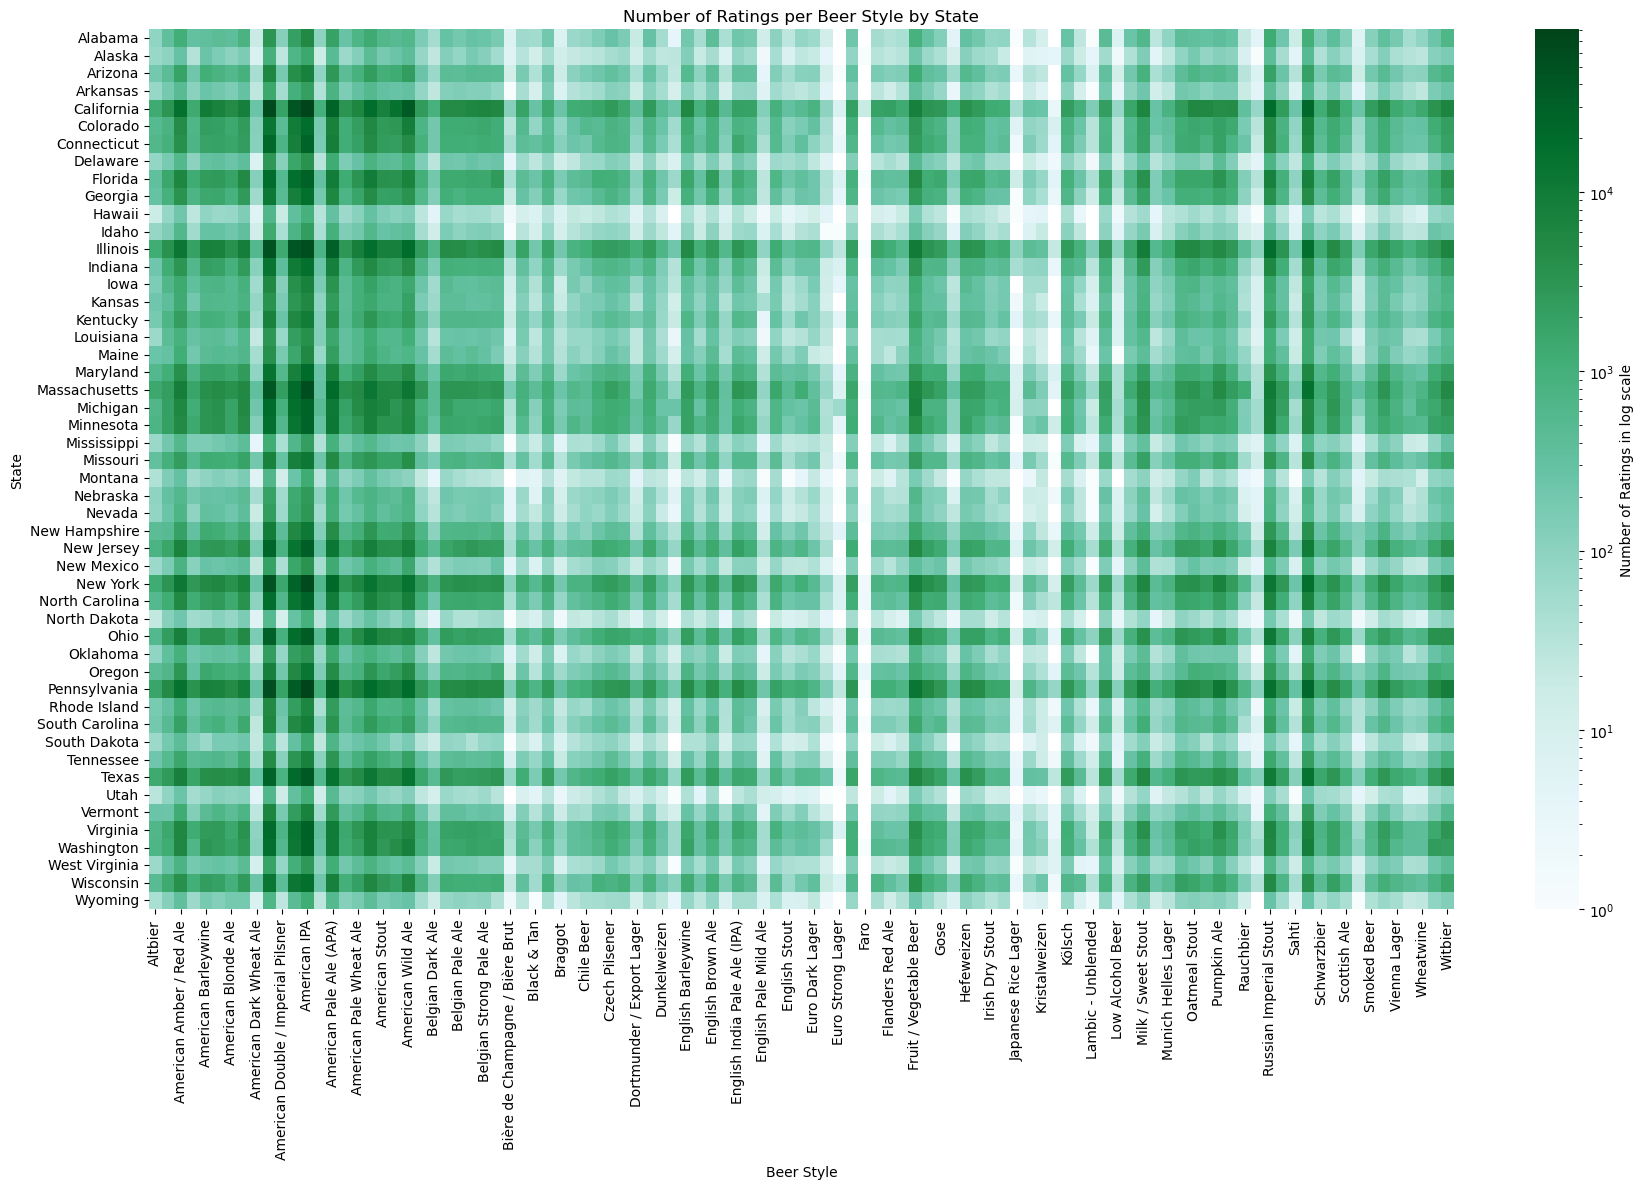

In [5]:
# heatmap to visualize in log scale in order to be more representative
state_style_nb_ratings_table = state_style_stats.pivot_table(index='user_state', columns='style', values='nb_ratings', fill_value=0)

plt.figure(figsize=(18, 12))
sns.heatmap(state_style_nb_ratings_table, cmap='BuGn', annot=False, norm=LogNorm(), cbar_kws={'label': 'Number of Ratings in log scale'})
plt.xlabel('Beer Style')
plt.ylabel('State')
plt.title('Number of Ratings per Beer Style by State')
plt.xticks(rotation=90)  #for readability
plt.tight_layout()
plt.show()


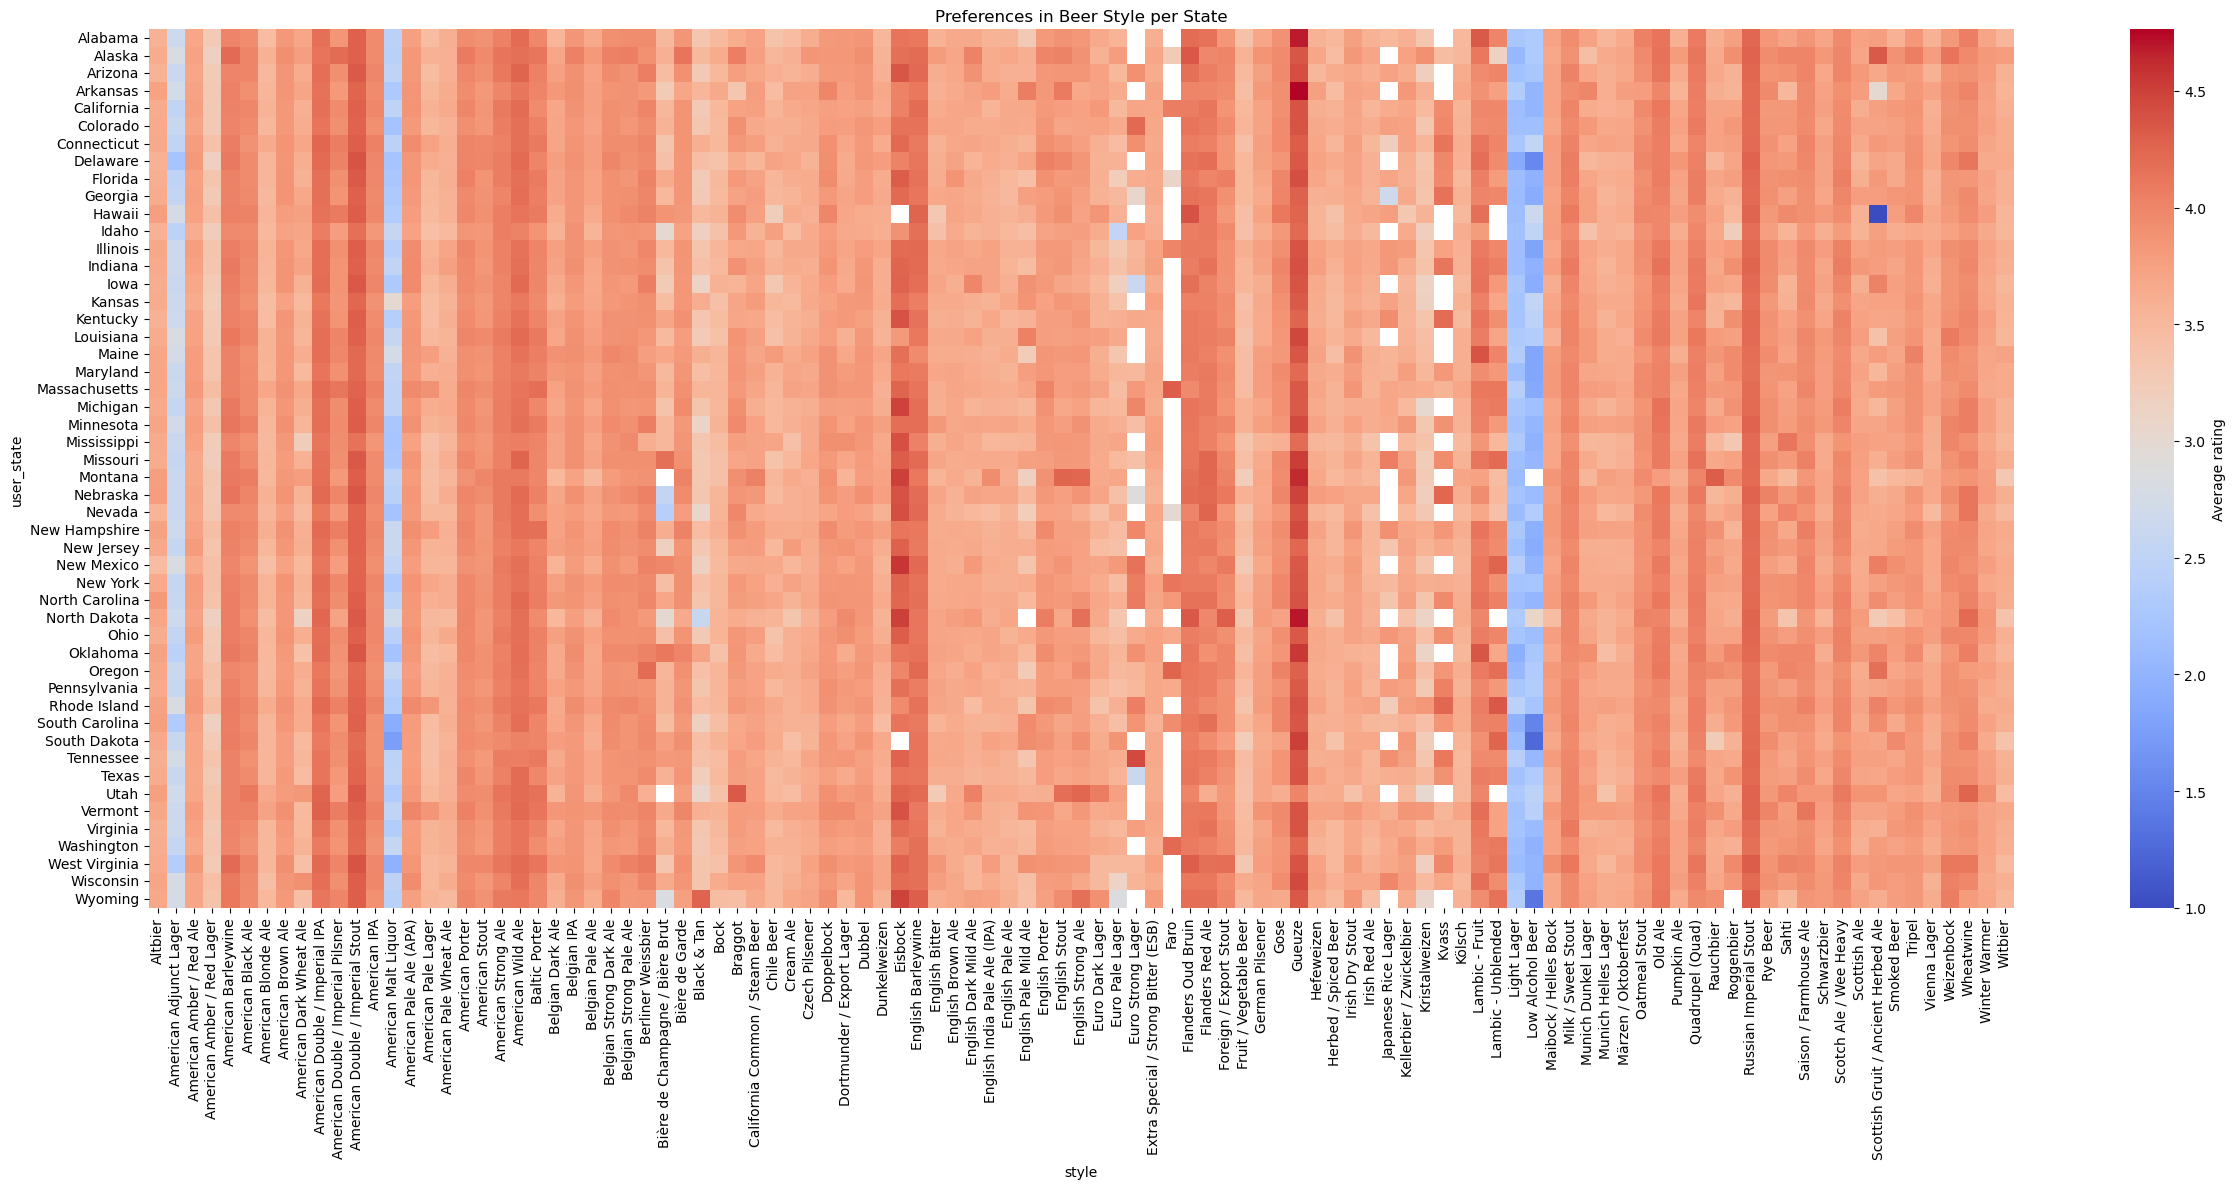

In [6]:
# table with all average beer ratings per style for each state
state_style_average_rating_table = state_style_stats.pivot_table(index='user_state', columns='style', values='average_rating')

# heatmap to vizualise preferences in beer style per state
plt.figure(figsize=(25, 12))
sns.heatmap(state_style_average_rating_table, annot=False, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Average rating'})
plt.xticks(rotation=90)
plt.title('Preferences in Beer Style per State')
plt.tight_layout()
plt.show()

We need to take in account both the number of ratings and the maximum rating per style per state, because for example if a style has only one high rating it is not very relevant. Therefore we define the weight as the multiplication of the average rating and number of rating per style and state.

/tmp/ipykernel_545183/930055799.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_style_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['weight'].idxmax()]).reset_index(drop=True)


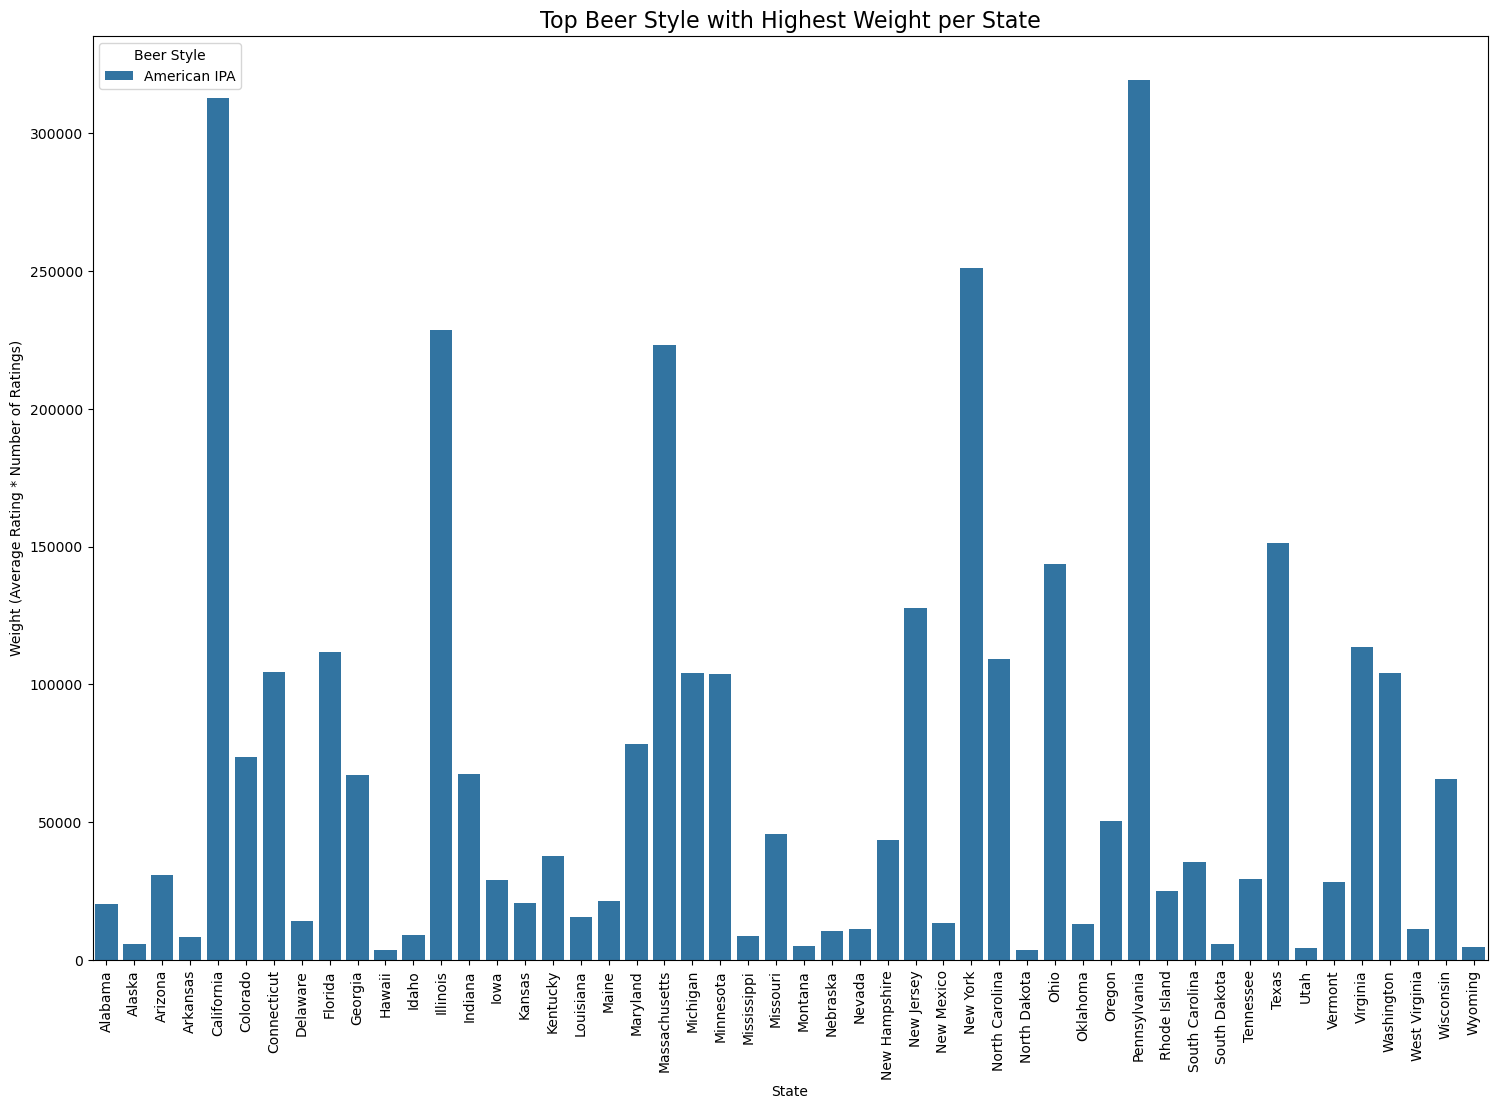

        user_state         style     weight
0          Alabama  American IPA   20175.45
1           Alaska  American IPA    5924.35
2          Arizona  American IPA   30753.18
3         Arkansas  American IPA    8434.31
4       California  American IPA  312655.26
5         Colorado  American IPA   73759.44
6      Connecticut  American IPA  104614.82
7         Delaware  American IPA   14160.93
8          Florida  American IPA  111876.99
9          Georgia  American IPA   67119.94
10          Hawaii  American IPA    3676.58
11           Idaho  American IPA    8959.49
12        Illinois  American IPA  228407.04
13         Indiana  American IPA   67461.95
14            Iowa  American IPA   28970.84
15          Kansas  American IPA   20841.47
16        Kentucky  American IPA   37870.17
17       Louisiana  American IPA   15618.33
18           Maine  American IPA   21567.44
19        Maryland  American IPA   78329.40
20   Massachusetts  American IPA  223257.64
21        Michigan  American IPA

In [7]:
state_style_stats['weight'] = state_style_stats['average_rating'] * state_style_stats['nb_ratings']

# beer style with maximum weight per state
top_style_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['weight'].idxmax()]).reset_index(drop=True)

plt.figure(figsize=(18, 12))
sns.barplot(data=top_style_per_state, x='user_state', y='weight', hue='style')
plt.title("Top Beer Style with Highest Weight per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Weight (Average Rating * Number of Ratings)')
plt.legend(title='Beer Style', loc='upper left')
plt.show()

print(top_style_per_state[['user_state', 'style', 'weight']])


We can see that most of the people in every state rate a lot the American IPA beers so even if it is not the style with the highest rating, it is the one which has the highest weight in every state.

/tmp/ipykernel_545183/3716610936.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_2_styles_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.nlargest(2, 'weight')).reset_index(drop=True)


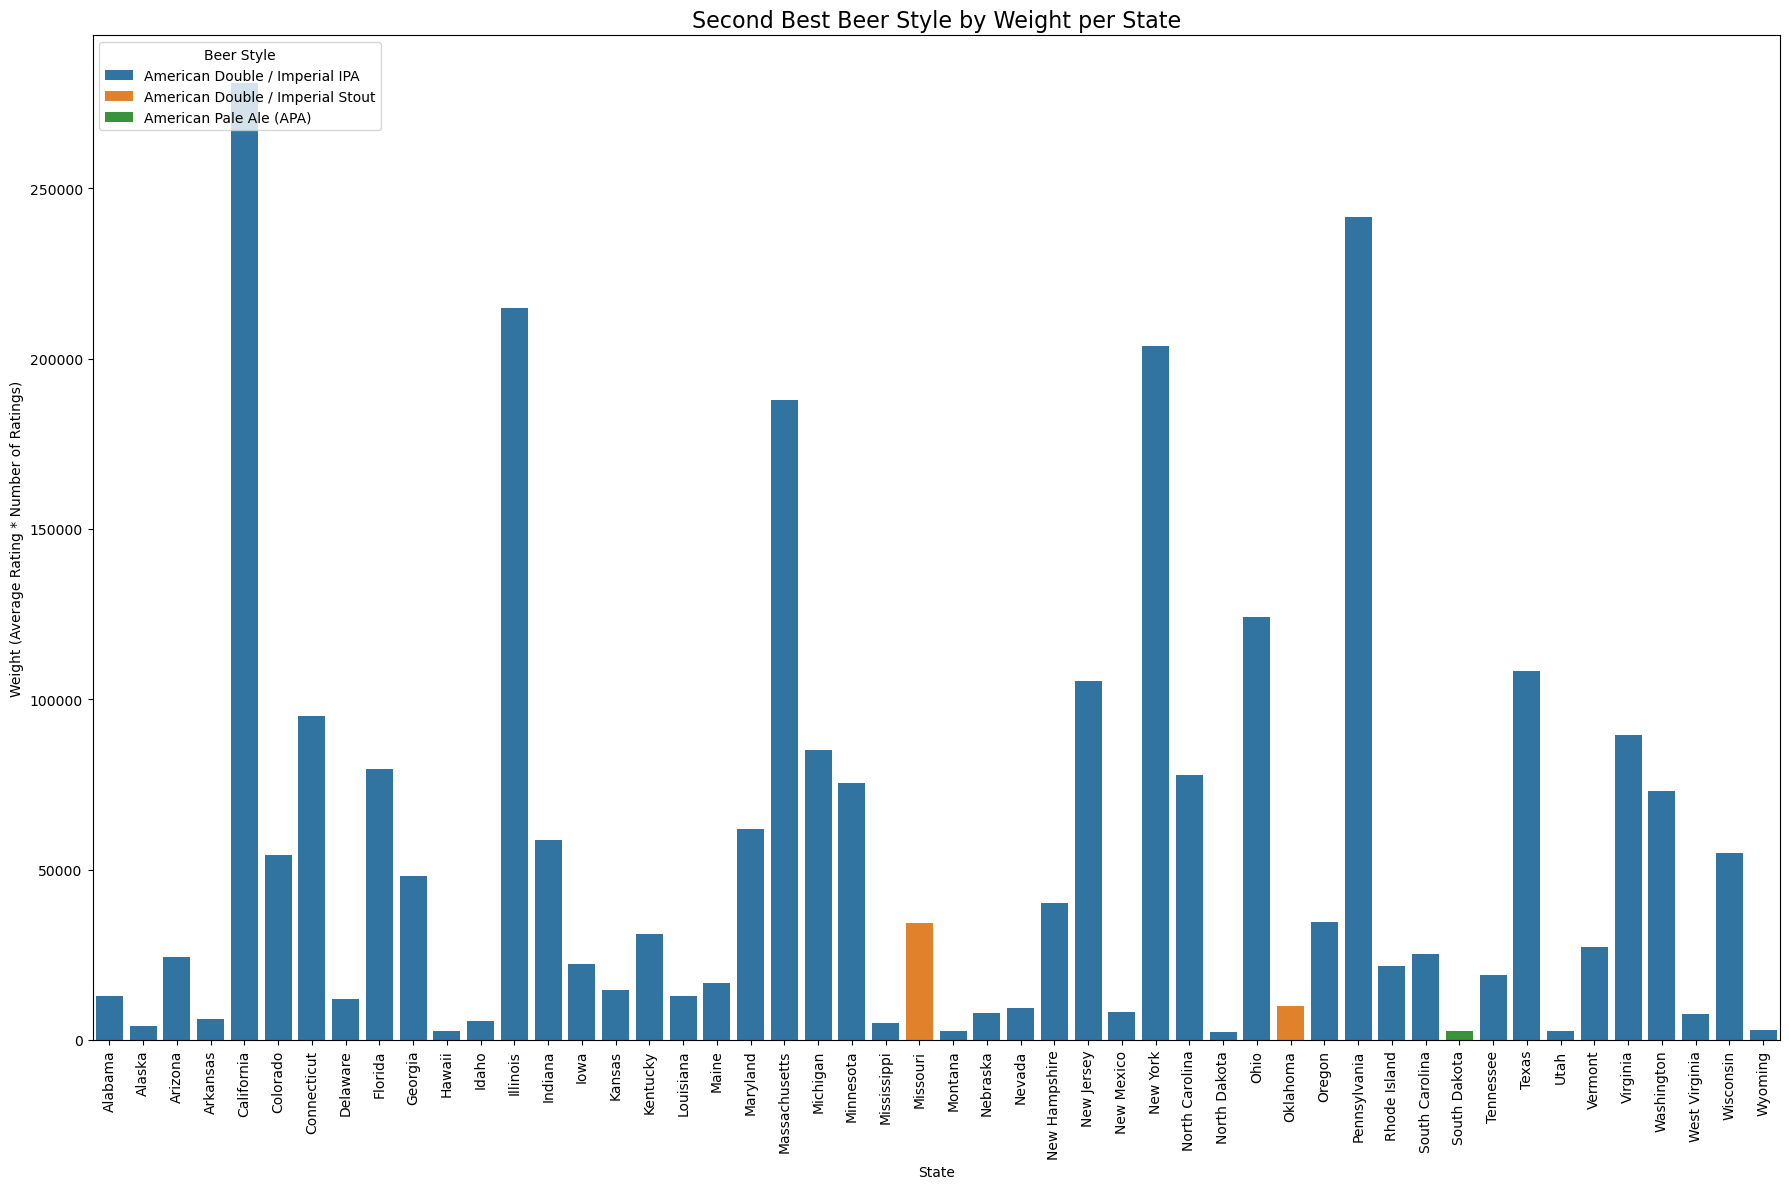

        user_state                             style     weight
0          Alabama    American Double / Imperial IPA   13032.65
1           Alaska    American Double / Imperial IPA    4191.37
2          Arizona    American Double / Imperial IPA   24391.98
3         Arkansas    American Double / Imperial IPA    6106.70
4       California    American Double / Imperial IPA  280860.63
5         Colorado    American Double / Imperial IPA   54152.47
6      Connecticut    American Double / Imperial IPA   95175.75
7         Delaware    American Double / Imperial IPA   12008.46
8          Florida    American Double / Imperial IPA   79531.98
9          Georgia    American Double / Imperial IPA   48109.53
10          Hawaii    American Double / Imperial IPA    2705.05
11           Idaho    American Double / Imperial IPA    5473.06
12        Illinois    American Double / Imperial IPA  214776.03
13         Indiana    American Double / Imperial IPA   58682.28
14            Iowa    American Double / 

In [8]:
# Second best weighted style per state
top_2_styles_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.nlargest(2, 'weight')).reset_index(drop=True)

second_best_styles = top_2_styles_per_state.groupby('user_state').nth(1).reset_index()

plt.figure(figsize=(18, 12))
sns.barplot(data=second_best_styles, x='user_state', y='weight', hue='style')
plt.title("Second Best Beer Style by Weight per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Weight (Average Rating * Number of Ratings)')
plt.legend(title='Beer Style', loc='upper left')
plt.tight_layout()
plt.show()

print(second_best_styles[['user_state', 'style', 'weight']])

We saw before that American IPA is very rated compared to other beer styles and we need to take in account this in the weight calculation. Therefore we used the log function in order to ajust with the global popularity

In [9]:
min_ratings_threshold = state_style_stats['nb_ratings'].quantile(0.25) # threshold for minimum ratings
print('value threshold', min_ratings_threshold)
state_style_stats = state_style_stats[state_style_stats['nb_ratings'] >= min_ratings_threshold]

state_style_stats['weight'] = state_style_stats['average_rating'] * np.log1p(state_style_stats['nb_ratings'])
state_style_stats['normalized_weight'] = state_style_stats['weight'] / state_style_stats.groupby('user_state')['weight'].transform('sum')

# global popularity adjustment, account for overall beer style preferences like American IPA for example
global_popularity = state_style_stats.groupby('style')['nb_ratings'].sum()
global_popularity_normalized = global_popularity / global_popularity.max()
state_style_stats['bias_adjusted_weight'] = state_style_stats['weight'] / state_style_stats['style'].map(global_popularity_normalized)

value threshold 61.0


/tmp/ipykernel_545183/3093619460.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_style_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['normalized_weight'].idxmax()]).reset_index(drop=True)


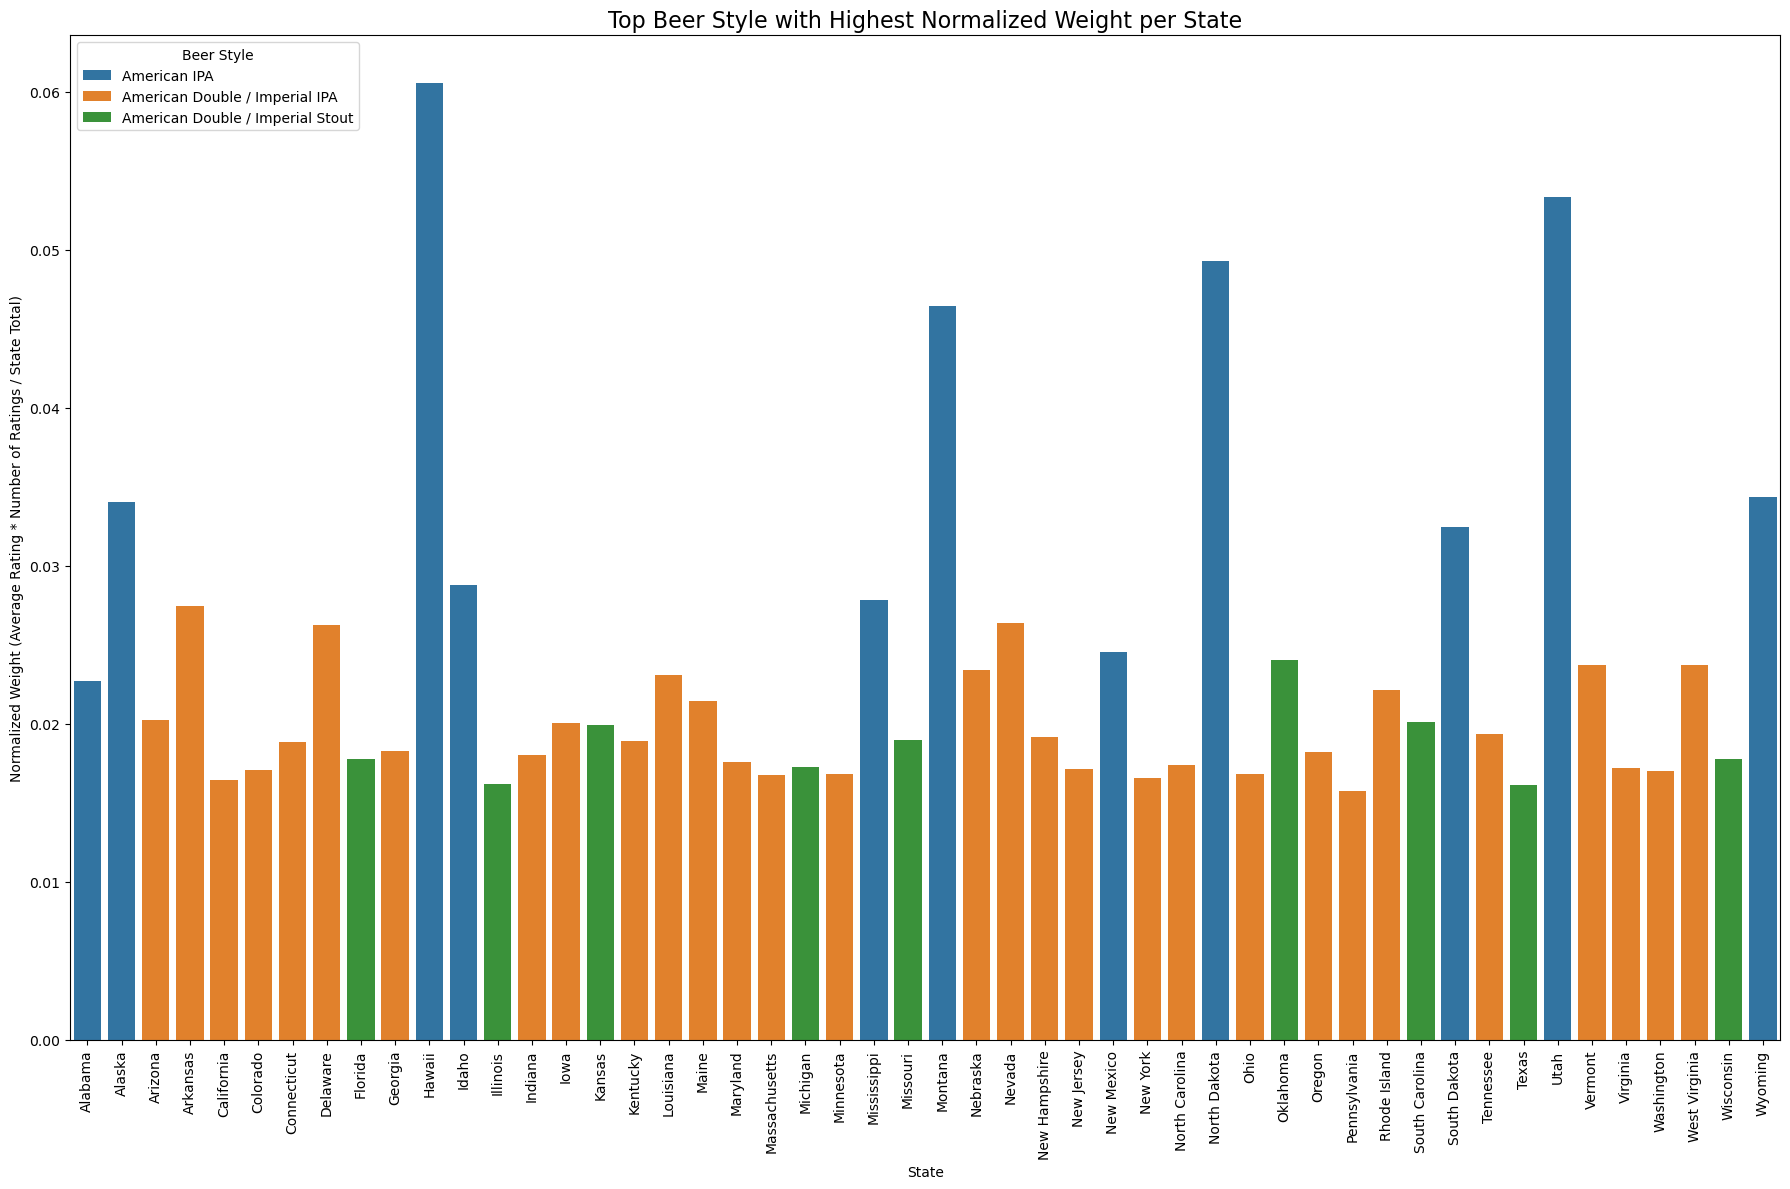

In [10]:
# top beer style per state based on normalized weight
top_style_per_state = state_style_stats.groupby('user_state').apply(lambda x: x.loc[x['normalized_weight'].idxmax()]).reset_index(drop=True)

plt.figure(figsize=(18, 12))
sns.barplot(data=top_style_per_state, x='user_state', y='normalized_weight', hue='style')
plt.title("Top Beer Style with Highest Normalized Weight per State", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Normalized Weight (Average Rating * Number of Ratings / State Total)')
plt.legend(title='Beer Style', loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
print(top_style_per_state.shape)
top_style_per_state.rename(columns={'style': 'preferred_style_beer'}, inplace=True)
top_style_per_state.head()

(50, 7)


,user_state,preferred_style_beer,average_rating,nb_ratings,weight,normalized_weight,bias_adjusted_weight
0,Alabama,American IPA,3.945912,5113,33.697055,0.022728,33.697055
1,Alaska,American IPA,3.952201,1499,28.903320,0.034065,28.903320
2,Arizona,American Double / Imperial IPA,4.185309,5828,36.289142,0.020248,47.675112
3,Arkansas,American Double / Imperial IPA,4.151394,1471,30.281831,0.027437,39.782966
4,California,American Double / Imperial IPA,4.161083,67497,46.270634,0.016471,60.788366


Missing states: {'District of Columbia', 'Puerto Rico'}
Index(['id', 'name', 'density', 'geometry', 'user_state',
       'preferred_style_beer', 'average_rating', 'nb_ratings', 'weight',
       'normalized_weight', 'bias_adjusted_weight'],
      dtype='object')
Index(['user_state', 'preferred_style_beer', 'average_rating', 'nb_ratings',
       'weight', 'normalized_weight', 'bias_adjusted_weight'],
      dtype='object')


/tmp/ipykernel_545183/439445925.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  us_states['preferred_style_beer'].fillna("No Data", inplace=True)


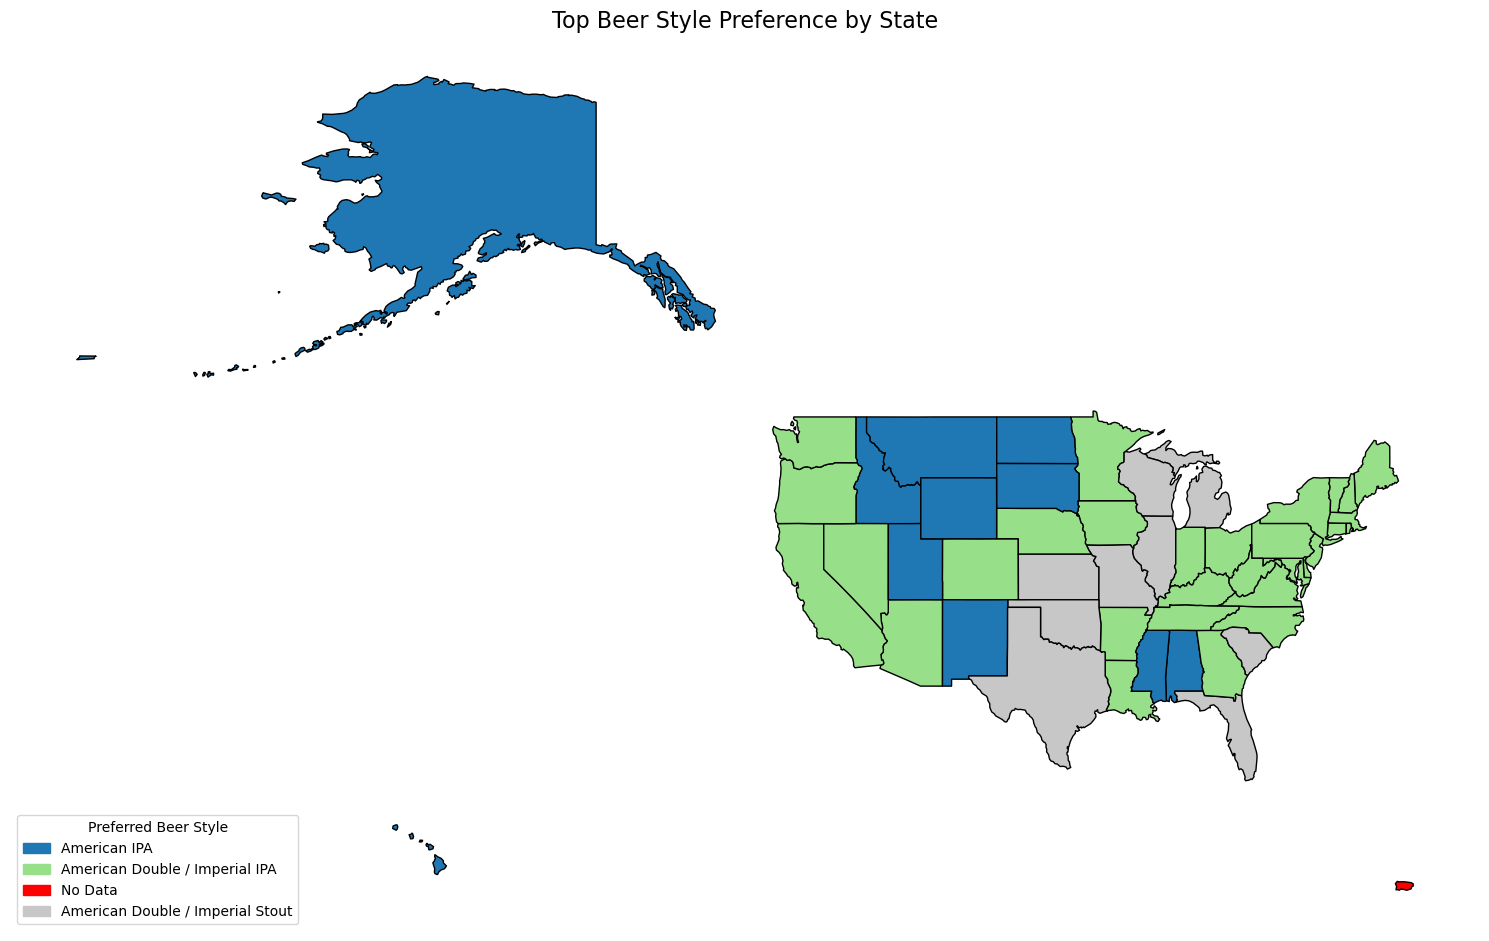

In [12]:
import geopandas as gpd
import matplotlib.patches as mpatches

# Load US States shapefile (GeoJSON)
us_states = gpd.read_file("https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json")

all_states = us_states['name'].unique()
matched_states = top_style_per_state['user_state'].unique()
missing_states = set(all_states) - set(matched_states)
print("Missing states:", missing_states)

for state in missing_states:
    top_style_per_state = pd.concat([
        top_style_per_state, 
        pd.DataFrame({'user_state': [state], 'preferred_style_beer': ['No Data']})
    ])

us_states = us_states.merge(
    top_style_per_state, 
    left_on="name", 
    right_on="user_state", 
    how="left"
)

us_states['preferred_style_beer'].fillna("No Data", inplace=True)

print(us_states.columns)
print(top_style_per_state.columns)

unique_styles = us_states['preferred_style_beer'].unique()
style_colors = {
    style: plt.cm.tab20(i / len(unique_styles)) if style != "No Data" else "red"
    for i, style in enumerate(unique_styles)
}

us_states['color'] = us_states['preferred_style_beer'].map(style_colors)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
us_states.plot(
    ax=ax,
    color=us_states['color'],
    edgecolor='black'
)

legend_patches = [mpatches.Patch(color=color, label=style) for style, color in style_colors.items()]
ax.legend(handles=legend_patches, title="Preferred Beer Style", loc="lower left", fontsize=10)
ax.set_title("Top Beer Style Preference by State", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


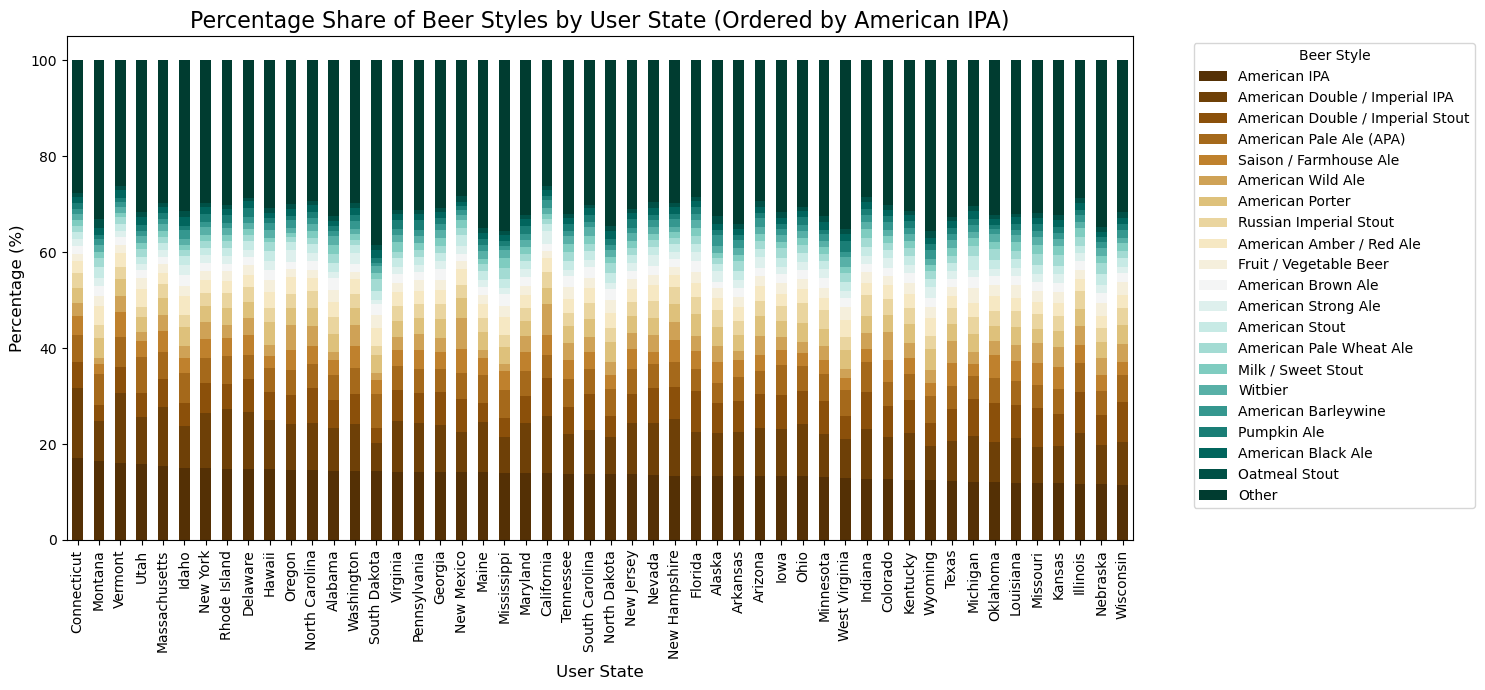

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame `US_ratings` setup
# Replace with your actual data
# US_ratings = pd.read_csv('your_data.csv')

top_5_styles = US_ratings['style'].value_counts().head(20).index

# Group styles into categories (Top 5 + "Other")
US_ratings['style_category'] = US_ratings['style'].apply(
    lambda x: x if x in top_5_styles else 'Other'
)

style_counts = US_ratings.groupby(['user_state', 'style_category']).size().unstack(fill_value=0)

style_percentages = style_counts.div(style_counts.sum(axis=1), axis=0) * 100

global_order = (
    style_counts.sum(axis=0)
    .sort_values(ascending=False)
    .index.tolist()
)

# Ensure "Other" is at the top
if "Other" in global_order:
    global_order.remove("Other")
    global_order.append("Other")

style_percentages = style_percentages[global_order]

# Sort states by percentage of American IPA
if 'American IPA' in style_percentages.columns:
    style_percentages = style_percentages.sort_values(by='American IPA', ascending=False)


colours_palette = [
    '#a7b35c', '#4f0205', '#a46e51', '#6e6456', '#dd660d', '#3d5d44', 
    '#5b8a72', '#7a5429', '#5f3f36', '#d1a85c', '#8f6b3e', '#ff920d', 
    '#be9c69', '#b8895a', '#92714c', '#6c5e4f', '#8a4632', '#b25a3c',
    '#c4b27a', '#735647', '#d19146'
]

style_percentages.plot(kind='bar', stacked=True, figsize=(15, 7), cmap='BrBG')

plt.title('Percentage Share of Beer Styles by User State (Ordered by American IPA)', fontsize=16)
plt.xlabel('User State', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Beer Style', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
